# Chicago Total Bike Share (Month Aggregated)

**Code used to aggregate by month/day**

In [218]:
# #Group dates
# bike_df.Date = pd.to_datetime(bike_df.Date)
# bike_df['Month'] = bike_df.Date.dt.month
# bike_df['Day'] = bike_df.Date.dt.day

# bike_df = bike_df.dropna(how = 'any')

# bike_df.drop(bike_df[['Date', 'DAILYSnowDepth','DAILYSnowDepth']], axis = 1, inplace = True)

# #Create stats dict for column stats
# f = {'Customer_sum': 'sum', 'Subscriber_sum': 'sum', 'Total_Count sum': 'sum', 'Season': 'mean', 'Holiday': 'mean', 'Duration_mean': 'mean', 'DAILYAverageDryBulbTemp': 'mean', 'DAILYDeptFromNormalAverageTemp': 'mean', 'DAILYAverageRelativeHumidity': 'mean', 'DAILYCoolingDegreeDays': 'mean', 'DAILYSunrise': 'mean', 'DAILYSunset': 'mean', 'DAILYAverageStationPressure': 'mean', 'DAILYAverageWindSpeed': 'mean', 'DAILYSustainedWindSpeed': 'mean', 'DAILYSustainedWindDirection': 'mean'}

# #Aggregate data by day
# bike_df = bike_df.groupby(['Month', 'Day']).agg(f) #Groupby day and apply
# bike_df.to_csv('Chicago_aggregated.csv')

**Import pacakges**

In [219]:
import warnings
warnings.filterwarnings('ignore')

In [220]:
import pandas.io.data as web
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels as sm
import seaborn as sns
import pylab
import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as smgraph
import scipy.stats as stats

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from pandas.tools.plotting import scatter_matrix
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, f1_score
from math import sqrt

%matplotlib inline
sns.set_palette("Set2", 10) #Set color scheme
sns.set_style("darkgrid") #Set style for axis
pd.set_option('display.max_rows', 500)

In [221]:
#Import data files
bike_df = pd.read_csv('Chicago_aggregated.csv')
model_df = bike_df.copy() #df copy to model with

In [222]:
model_df.head()

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Season_Name,Holiday,Duration_mean,DAILYSunset,DAILYAverageStationPressure,DAILYSustainedWindSpeed,DAILYSustainedWindDirection,DAILYAverageWindSpeed,DAILYSunrise,DAILYCoolingDegreeDays,DAILYAverageRelativeHumidity,DAILYDeptFromNormalAverageTemp,DAILYAverageDryBulbTemp
0,1,1,2287,6585,8872,1,Winter,1,18.242143,1632.0,29.396667,22.000000,186.666667,13.366667,720.0,0.0,70.333333,-3.066667,21.333333
1,1,2,2748,10685,13433,1,Winter,0,16.233118,1633.0,29.430000,19.000000,250.000000,9.800000,720.0,0.0,71.333333,-4.300000,20.000000
2,1,3,1534,6782,8316,1,Winter,0,13.581355,1634.0,29.333333,23.000000,223.333333,10.700000,720.0,0.0,76.666667,-3.533333,20.666667
3,1,4,935,10190,11125,1,Winter,0,12.048118,1635.0,29.426667,24.333333,286.666667,13.366667,720.0,0.0,72.000000,-1.100000,23.000000
4,1,5,677,11515,12192,1,Winter,0,10.912920,1636.0,29.566667,24.666667,276.666667,12.366667,720.0,0.0,71.333333,-10.666667,13.333333


In [223]:
#Season dummy
season_dummy = pd.get_dummies(model_df.Season_Name)
model_df = pd.concat([model_df, season_dummy], axis = 1)
model_df.drop(['Season_Name'], axis = 1, inplace = True)

#Drop NaN rows
model_df = model_df.dropna(how = 'any')

#Outlier adjust 
# model_df = model_df[model_df['Total_Count sum'] > 13000]
#Chose to keep these points in the model as the are all from the winter season (below)

In [224]:
model_df[model_df['Total_Count sum'] < 13000]

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,Duration_mean,DAILYSunset,DAILYAverageStationPressure,...,DAILYAverageWindSpeed,DAILYSunrise,DAILYCoolingDegreeDays,DAILYAverageRelativeHumidity,DAILYDeptFromNormalAverageTemp,DAILYAverageDryBulbTemp,Fall,Spring,Summer,Winter
0,1,1,2287,6585,8872,1,1,18.242143,1632.000000,29.396667,...,13.366667,720.000000,0.0,70.333333,-3.066667,21.333333,0.0,0.0,0.0,1.0
2,1,3,1534,6782,8316,1,0,13.581355,1634.000000,29.333333,...,10.700000,720.000000,0.0,76.666667,-3.533333,20.666667,0.0,0.0,0.0,1.0
3,1,4,935,10190,11125,1,0,12.048118,1635.000000,29.426667,...,13.366667,720.000000,0.0,72.000000,-1.100000,23.000000,0.0,0.0,0.0,1.0
4,1,5,677,11515,12192,1,0,10.912920,1636.000000,29.566667,...,12.366667,720.000000,0.0,71.333333,-10.666667,13.333333,0.0,0.0,0.0,1.0
5,1,6,421,10930,11351,1,0,10.762548,1637.000000,29.503333,...,13.800000,720.000000,0.0,67.333333,-16.900000,7.000000,0.0,0.0,0.0,1.0
6,1,7,465,11520,11985,1,0,10.587834,1638.000000,29.570000,...,11.500000,720.000000,0.0,62.666667,-12.566667,11.333333,0.0,0.0,0.0,1.0
9,1,10,1196,9022,10218,1,0,11.531419,1641.000000,29.293333,...,13.300000,719.000000,0.0,76.666667,-4.700000,19.000000,0.0,0.0,0.0,1.0
10,1,11,888,10876,11764,1,0,10.916087,1642.000000,29.170000,...,10.600000,719.000000,0.0,76.000000,1.400000,25.000000,0.0,0.0,0.0,1.0
17,1,18,829,7570,8399,1,1,11.132862,1650.000000,29.270000,...,10.300000,715.000000,0.0,71.666667,-6.733333,16.666667,0.0,0.0,0.0,1.0
18,1,19,1395,11349,12744,1,1,12.676798,1651.000000,29.276667,...,8.433333,715.000000,0.0,70.000000,-1.733333,21.666667,0.0,0.0,0.0,1.0


In [225]:
#Create dependent variable
y = model_df['Total_Count sum']

#Create independent variables
X = model_df.ix[:,'Holiday': 'Winter']

#Final model variables to drop (In order of highest p-value > .05)
# X.drop(['DAILYSustainedWindDirection', 'Duration_mean', 'DAILYAverageStationPressure', 'DAILYSunset', 'DAILYAverageWindSpeed', 'DAILYSustainedWindSpeed', 'DAILYCoolingDegreeDays','DAILYAverageRelativeHumidity'], axis = 1, inplace = True)
X.drop(['DAILYCoolingDegreeDays', 'DAILYAverageWindSpeed', 'DAILYAverageRelativeHumidity', 'DAILYSustainedWindSpeed', 'DAILYSustainedWindDirection', 'DAILYAverageStationPressure'], axis = 1, inplace = True)
# 'Winter','Spring', 'Summer', 'Fall'

# Data Set Decriptive Stats

In [226]:
model_df.describe()

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,Duration_mean,DAILYSunset,DAILYAverageStationPressure,...,DAILYAverageWindSpeed,DAILYSunrise,DAILYCoolingDegreeDays,DAILYAverageRelativeHumidity,DAILYDeptFromNormalAverageTemp,DAILYAverageDryBulbTemp,Fall,Spring,Summer,Winter
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,...,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,6.526912,15.220963,6027.192635,21764.410765,27791.603399,2.504249,0.033994,15.890705,1777.822946,29.297934,...,9.827644,557.257790,2.454674,66.939566,-0.555571,49.388338,0.249292,0.252125,0.252125,0.246459
std,3.452599,8.520157,4287.794510,8910.248591,12415.061002,1.115800,0.181472,3.380873,109.687400,0.125238,...,2.428847,105.701509,3.681170,7.679163,5.888779,20.270839,0.433217,0.434849,0.434849,0.431561
min,1.000000,1.000000,4.000000,52.000000,56.000000,1.000000,0.000000,9.720214,1620.000000,28.730000,...,3.700000,415.333333,0.000000,40.000000,-23.400000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,2084.000000,17138.000000,19847.000000,2.000000,0.000000,13.179857,1656.000000,29.216667,...,8.066667,446.250000,0.000000,63.000000,-3.100000,32.750000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,15.000000,5831.000000,22986.000000,28915.000000,3.000000,0.000000,16.179038,1800.666667,29.296667,...,9.575000,542.666667,0.000000,67.000000,0.366667,52.333333,0.000000,0.000000,0.000000,0.000000
75%,10.000000,23.000000,8998.000000,28849.000000,37797.000000,3.000000,0.000000,18.243569,1890.500000,29.377500,...,11.333333,645.000000,5.000000,72.333333,3.400000,69.250000,0.000000,1.000000,1.000000,0.000000
max,12.000000,30.000000,21201.000000,38472.000000,48582.000000,4.000000,1.000000,27.652075,1931.000000,29.680000,...,23.300000,720.000000,14.000000,85.500000,12.800000,79.000000,1.000000,1.000000,1.000000,1.000000


# Dependent Variable Distributions

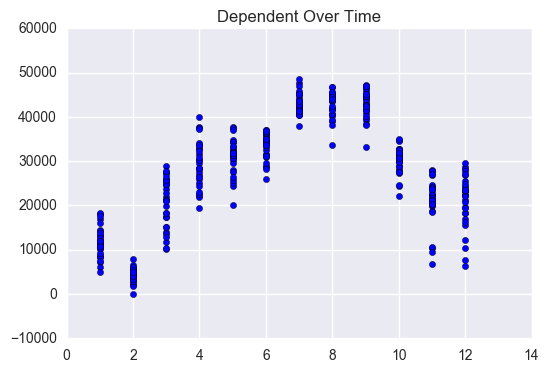

In [227]:
#Count over time
plt.scatter(model_df.Month, model_df['Total_Count sum'])
plt.title('Dependent Over Time')

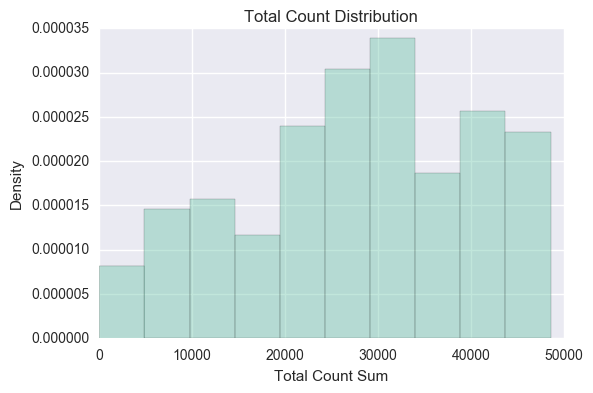

In [228]:
#Dependent distributions
ax = sns.distplot(model_df['Total_Count sum'], kde = False, rug = False, norm_hist = True)
plt.title('Total Count Distribution')
plt.xlabel('Total Count Sum')
ax.set_ylabel('Density')
plt.show()

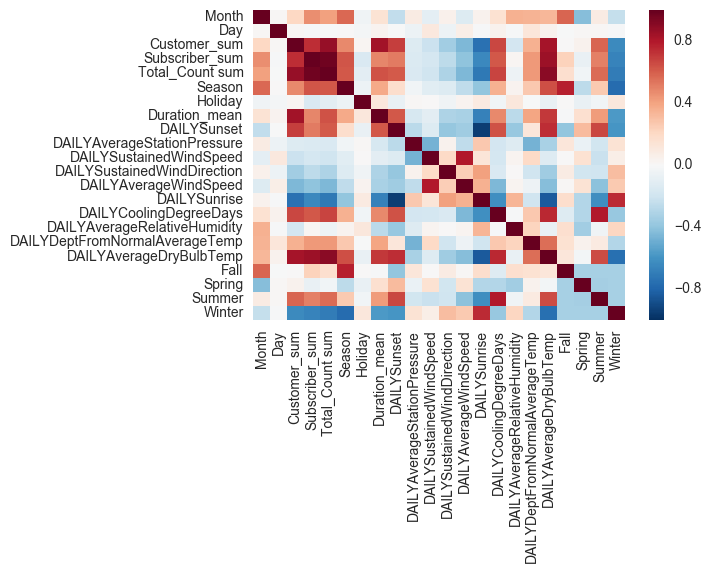

In [229]:
#Correlation Heatmap
corr = model_df.corr()
sns.heatmap(corr)

In [230]:
#Correlation Values List
corr = pd.DataFrame(model_df.corr())
corr.dropna(how='any')

#Dropped (Based on correlation and heatmap > .90): 
# DAILYMaximumDryBulbTemp DAILYMinimumDryBulbTemp (Kept average)
# DAILYAverageSeaLevelPressure (Lower corr to dependent since redundant)
# DAILYPeakWindSpeed PeakWindDirection (Kept Average)
# DAILYAverageDewPointTemp DAILYAverageWetBulbTemp (Lower corr to dependent since redundant)

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,Duration_mean,DAILYSunset,DAILYAverageStationPressure,...,DAILYAverageWindSpeed,DAILYSunrise,DAILYCoolingDegreeDays,DAILYAverageRelativeHumidity,DAILYDeptFromNormalAverageTemp,DAILYAverageDryBulbTemp,Fall,Spring,Summer,Winter
Month,1.000000,0.012255,0.210513,0.466006,0.407156,0.573880,-0.046806,0.142740,-0.242599,0.082269,...,-0.138087,0.040277,0.153378,0.357777,0.348517,0.328887,0.580502,-0.425552,0.081564,-0.236121
Day,0.012255,1.000000,0.014738,-0.013404,-0.004530,0.005280,-0.021408,0.033762,-0.000644,-0.059644,...,0.067657,-0.008662,0.041609,-0.011635,0.121430,0.043309,-0.003421,0.007924,0.007924,-0.012535
Customer_sum,0.210513,0.014738,1.000000,0.737542,0.874702,0.476770,0.021730,0.840771,0.693600,-0.138510,...,-0.450562,-0.744141,0.670780,-0.186118,0.357965,0.834873,0.005685,0.046299,0.580039,-0.636817
Subscriber_sum,0.466006,-0.013404,0.737542,1.000000,0.972422,0.632106,-0.152917,0.484404,0.517234,-0.146817,...,-0.405838,-0.640727,0.618672,0.020138,0.430974,0.852526,0.229476,-0.073701,0.504905,-0.664846
Total_Count sum,0.407156,-0.004530,0.874702,0.972422,1.000000,0.618323,-0.102244,0.638033,0.610766,-0.153207,...,-0.446880,-0.716852,0.675687,-0.049827,0.432939,0.900195,0.166657,-0.036904,0.562697,-0.697096
Season,0.573880,0.005280,0.476770,0.632106,0.618323,1.000000,-0.056836,0.380551,0.177600,-0.038843,...,-0.251186,-0.395103,0.357802,0.031777,0.269227,0.640747,0.773583,-0.262765,0.258337,-0.772090
Holiday,-0.046806,-0.021408,0.021730,-0.152917,-0.102244,-0.056836,1.000000,0.113109,-0.076648,0.012473,...,0.033043,0.091626,-0.034898,0.111224,-0.000841,-0.073555,0.000307,-0.072919,-0.036918,0.110366
Duration_mean,0.142740,0.033762,0.840771,0.484404,0.638033,0.380551,0.113109,1.000000,0.617540,-0.171414,...,-0.327271,-0.678998,0.482067,-0.266935,0.394530,0.706471,-0.012176,0.156441,0.428212,-0.576886
DAILYSunset,-0.242599,-0.000644,0.693600,0.517234,0.610766,0.177600,-0.076648,0.617540,1.000000,-0.270923,...,-0.356123,-0.952927,0.639153,-0.379649,0.123204,0.739082,-0.398206,0.314031,0.665908,-0.587671
DAILYAverageStationPressure,0.082269,-0.059644,-0.138510,-0.146817,-0.153207,-0.038843,0.012473,-0.171414,-0.270923,1.000000,...,-0.255180,0.266278,-0.184972,-0.131539,-0.471717,-0.321623,0.119434,-0.068832,-0.193898,0.144839


# Categorical Boxplots

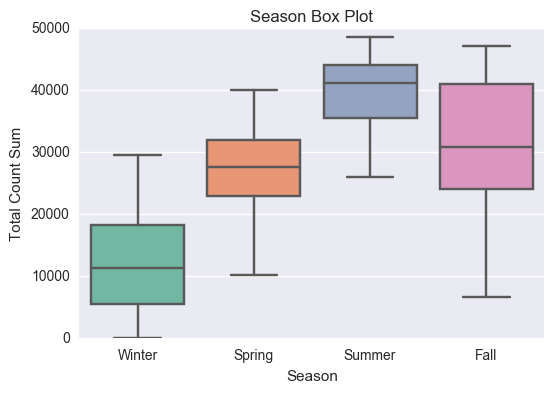

In [231]:
#Season df for labels
seasons_df = model_df[['Total_Count sum', 'Season']]

#Seasons Boxplots
ax = sns.boxplot(y, groupby = bike_df.Season_Name)
plt.title('Season Box Plot')
ax.set_ylabel('Total Count Sum')
plt.xlabel('Season')
plt.show()

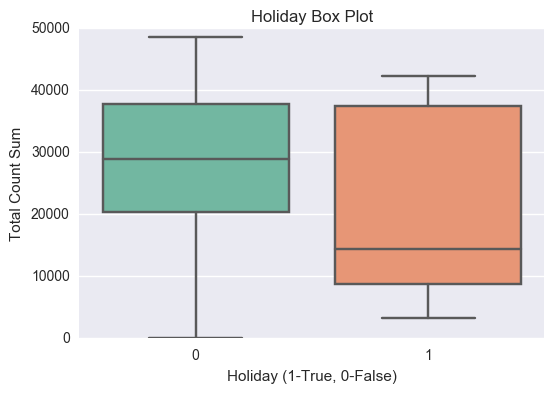

In [232]:
#Holiday Boxplots
ax = sns.boxplot(y, groupby = model_df.Holiday)
plt.title('Holiday Box Plot')
ax.set_ylabel('Total Count Sum')
plt.xlabel('Holiday (1-True, 0-False)')
plt.show()

# Training and Test Sets

In [233]:
#Training/Test set from sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7777)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(282, 10)
(282,)
(71, 10)
(71,)


# Linear Regression Model

In [234]:
#Linear regression model
lm = smf.OLS(y_train.astype(float), X_train.astype(float))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Total_Count sum   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     211.5
Date:                Sun, 04 Jun 2017   Prob (F-statistic):          2.65e-117
Time:                        10:47:48   Log-Likelihood:                -2768.4
No. Observations:                 282   AIC:                             5557.
Df Residuals:                     272   BIC:                             5593.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Holiday                        -2487.7491   1668.209     -1.491      0.137     -5771.992   796.494
Duration_mean                    259.0050    120.479      2.150      0.032        21.814   496.196
DAILYSunset                      -42.3376     12.758     -3.318      0.001       -67.455   -17.220
DAILYSunrise                      84.6764     15.837      5.347      0.000        53.497   115.856
DAILYDeptFromNormalAverageTemp -1196.2634    105.644    -11.324      0.000     -1404.247  -988.280
DAILYAverageDryBulbTemp         1341.1993     75.398     17.788      0.000      1192.762  1489.637
Fall                           -2.124e+04   2.95e+04     -0.719      0.473     -7.94e+04  3.69e+04
Spring                         -7048.1445   2.99e+04     -0.236      0.814     -6.59e+04  5.18e+04
Summer                         -1.825e+04   3.01e+04     -0.605      0.545     -7.76e+04  4.11e+04
Winter                         -1.345e+04   3.03e+04     -0.444      0.657     -7.31e+04  4.62e+04
==============================================================================
Omnibus:                        4.453   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                4.445
Skew:                          -0.307   Prob(JB):                        0.108
Kurtosis:                       2.951   Cond. No.                     4.15e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Residual Analysis

In [235]:
#Calculate residuals
predicted = results.fittedvalues
res = y_train - predicted

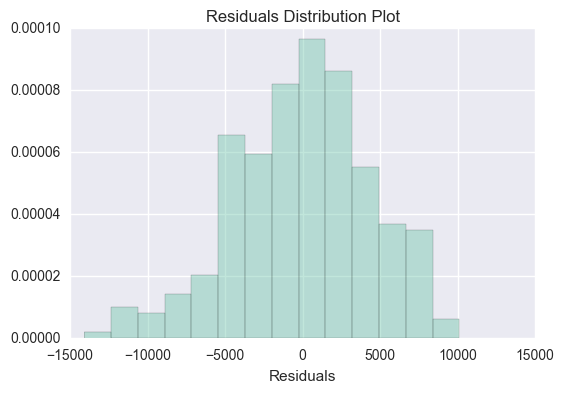

In [236]:
#Residual distribution
ax = sns.distplot(res, kde = False, rug = False, norm_hist = True)
plt.title('Residuals Distribution Plot')
plt.xlabel('Residuals')
plt.show()

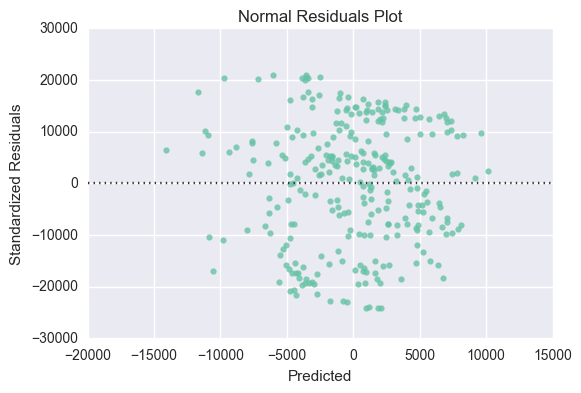

In [237]:
#Normal Residuals Plot
ax = sns.residplot(res, predicted)
plt.title('Normal Residuals Plot')
plt.xlabel('Predicted')
ax.set_ylabel('Standardized Residuals')
plt.show()

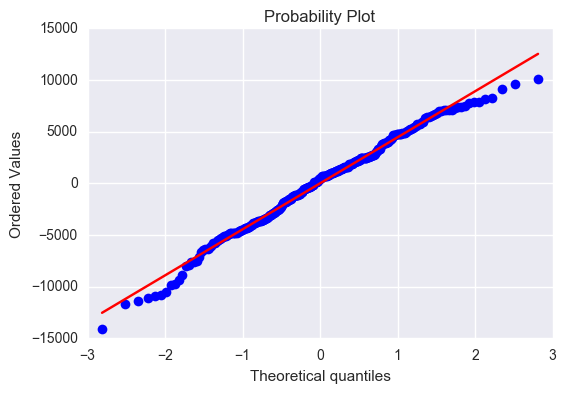

In [238]:
#Probability Plot
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(res, dist="norm", plot=pylab)
pylab.show()

# Feature Importance

In [239]:
# Feature Importance
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit an Extra Trees model to the data (fits n randomized decision trees on subsets of the data)
#uses averaging
model = ExtraTreesClassifier()
model.fit(X, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[ 0.01250471  0.19851028  0.19225176  0.18720435  0.19730507  0.19228242
  0.00598673  0.00652279  0.00373147  0.00370042]


[0.012504709630517438, 0.19851027622698819, 0.19225176407386374, 0.18720434782838877, 0.19730506858463959, 0.19228242375532414, 0.0059867309022388435, 0.0065227916008227067, 0.0037314702668865456, 0.003700417130329993]


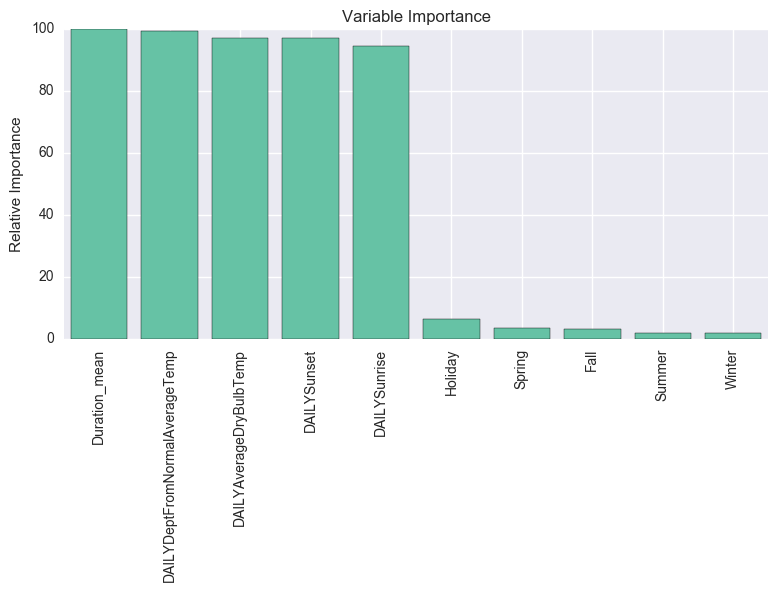

In [240]:
# Plot feature importance
feature_importance = model.feature_importances_
# normalize importances relative to max importance
print(list(feature_importance))
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance = feature_importance[0:50]
sorted_idx = np.argsort(feature_importance)[::-1][:50]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 2)
plt.bar(pos, feature_importance[sorted_idx], align='center')
plt.xticks(pos, X.columns[sorted_idx], rotation='vertical')
plt.ylabel('Relative Importance')
plt.title('Variable Importance')

plt.show()

# Predictions

Root Mean Square Error: 4160.253053714769


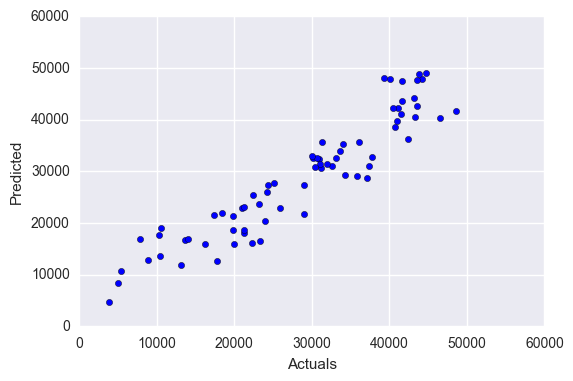

In [241]:
#Prediction on test set/plot predicted vs. actuals
preds = results.predict(X_test.astype(float))
plt.scatter(y_test, preds)
plt.xlabel('Actuals')
plt.ylabel('Predicted')
rms = sqrt(mean_squared_error(y_test, preds)) #RMSE
print('Root Mean Square Error: ' + str(rms))